In [ ]:
%%capture
!pip install qutip
!pip install tqdm

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qutip as q
from qutip import mesolve, steadystate
from numpy import pi, exp, sin, cos, sqrt, zeros, linspace, ones
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from cmath import phase
from tqdm.notebook import tqdm

In [ ]:
# Характерноые времена (в секундах)
T2_star = 0.4 * 1e-6  # s
T1 = 5 * 1e-3        # s
T1_op = 160 * 1e-6   # s

γ_T2_star = 1./(T2_star * 1e6) #МГц
γ_T1 = 1./(T1 * 1e6)          #МГц
γ_T1_op = 1./(T1_op * 1e6)     #МГц

σz = q.sigmaz()
σy = q.sigmay()
σx = q.sigmax()

# Диссипаторы
L_T1 = sqrt(γ_T1) * q.destroy(2)
L_T1_reverse = sqrt(γ_T1) * q.create(2)
L_T2_star = sqrt(γ_T2_star) * σz
L_T1_op = sqrt(γ_T1_op) * q.create(2)

c_ops = [L_T1, L_T2_star, L_T1_op, L_T1_reverse]

psi0 = q.basis(2, 1)

In [ ]:
# Параметры (в МГц)
ω_sys = 2800   # 2.8 GHz to MHz
ω0 = 2801      # MHz
Ω = 1e-2       # 10 kHz to MHz
d = 0.5        # MHz
ΩR = 0.1       # MHz
T = 2 * np.pi / Ω  # период модуляции

# Гамильтониан
H0 = -ω_sys / 2 * σz
H1 = -ΩR * σx
args = {'w': Ω, 'w0': ω0, 'd': d}

H = [H0, [H1, 'cos(w0*t)']]
H_rwa = -(ω_sys - ω0)/2 * σz - ΩR/2 * σx         # tlist = np.linspace(0, 100, 100)
H_mod = [H0, [H1, 'cos((w0 + d*sin(w * t))*t)']] # tlist = np.linspace(0, 5000, 1000)
H_mod_rwa = [[-ΩR/2 * σx, 'cos(d/w*cos(w * t))'], [-ΩR/2 * σy, 'sin(d/w*cos(w * t))']]
H_mod_rwa_rot = [-ΩR/2 * σx, [d/2*σz, 'sin(w*t)']]

tlist = linspace(0, T, 101)

result_rwa = mesolve(H_rwa, psi0, tlist, c_ops=c_ops, e_ops=[q.num(2)], args=args, options={"nsteps": 1e6, "progress_bar": "tqdm"})
result = mesolve(H_mod, psi0, tlist, c_ops=c_ops, e_ops=[q.num(2)], args=args, options={"nsteps": 1e7, "progress_bar": "tqdm"})

# Населённости
p_ex_rwa = result_rwa.expect[0]
p_ex = result.expect[0]


  0%|          | 0/100 [00:00<?, ?it/s]

[1/1] Cythonizing qtcoeff_6bd9efab7cca89705693d27fa4259f.pyx


INFO:root:running build_ext
INFO:root:building 'qtcoeff_6bd9efab7cca89705693d27fa4259f' extension
INFO:root:creating build/temp.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-g++ -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.11/dist-packages/qutip/core/data -I/usr/local/lib/python3.11/dist-packages/numpy/_core/include -I/usr/include/python3.11 -c qtcoeff_6bd9efab7cca89705693d27fa4259f.cpp -o build/temp.linux-x86_64-cpython-311/qtcoeff_6bd9efab7cca89705693d27fa4259f.o -w -O3 -funroll-loops
INFO:root:creating build/lib.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-g++ -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -shared -Wl,-O1 -Wl,-Bsymbolic-functions build/temp.linux-x86_64-cpython-311/qtcoeff_6bd9efab7cca89705693d27fa4259f.o -L/usr/lib/x86_64-linux-gnu -o build/lib.linux-x86_64-cpython-311/qtcoe

  0%|          | 0/100 [00:00<?, ?it/s]

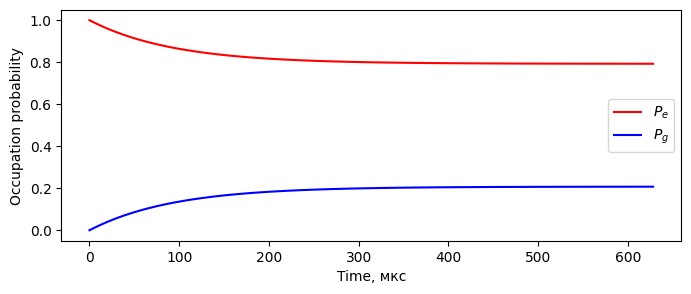

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(tlist, np.real(p_ex_rwa), 'r', label="$P_{e}$")
ax.plot(tlist, 1 - np.real(p_ex_rwa), 'b', label="$P_{g}$")
ax.set_xlabel('Time, мкс')
ax.set_ylabel('Occupation probability')
#ax.set_title("RWA")
ax.legend()
plt.show()

ΩR =  0.1 MHz , Δ =  -1 MHz
RWA p_ex =  0.7927233
no RWA p_ex =  0.8027662


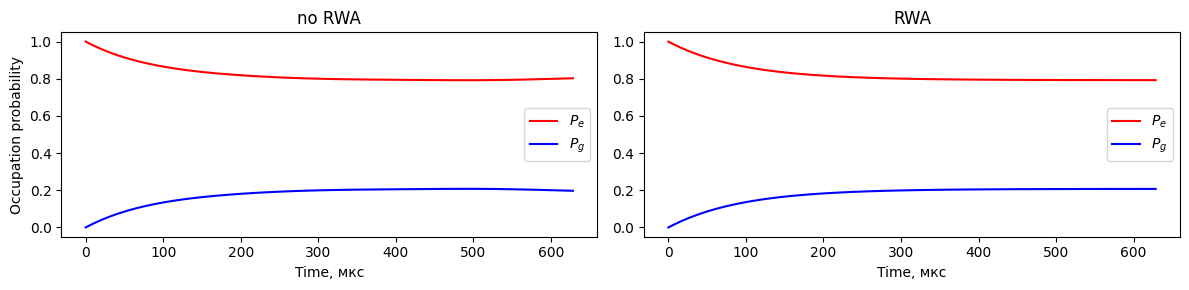

In [ ]:
print("ΩR = ", ΩR, "MHz , Δ = ",ω_sys - ω0, "MHz")
print("RWA p_ex = ", round(p_ex_rwa[-1], 7))
print("no RWA p_ex = ", round(p_ex[-1], 7))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Первый график (без RWA)
ax1.plot(tlist, np.real(p_ex), 'r', label="$P_{e}$")
ax1.plot(tlist, 1 - np.real(p_ex), 'b', label="$P_{g}$")
ax1.set_xlabel('Time, мкс')
ax1.set_ylabel('Occupation probability')
ax1.set_title("no RWA")
ax1.legend()

# Второй график (с RWA)
ax2.plot(tlist, np.real(p_ex_rwa), 'r', label="$P_{e}$")
ax2.plot(tlist, 1 - np.real(p_ex_rwa), 'b', label="$P_{g}$")
ax2.set_xlabel('Time, мкс')
#ax2.set_ylabel('Occupation probability')
ax2.set_title("RWA")
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
H_floquet = [-ΩR/2 * σx, [d/2*σz, 'sin(w*t)']]

###Зависимость стационарной населённости от отстройки Δ = ω0 - ω_sys

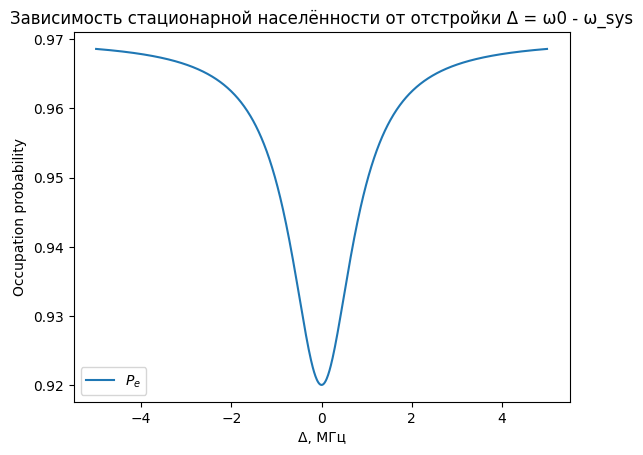

In [ ]:
# Параметры (в МГц)
ω_sys = 2800  # 2.8 GHz to MHz
ω0 = 2800
ΩR = 0.01       # MHz

H_rwa_stepper = lambda Δ: 2*pi*Δ / 2 * σz - 2*pi*ΩR / 2 * σx

Δ_mas, Δ_step = np.linspace(-5, 5, 1000, retstep = True)
occup = []

for Δ in Δ_mas:
    steady_state = q.steadystate(H_rwa_stepper(Δ), c_ops, method='direct')
    P_e = np.real((steady_state * q.num(2)).tr())  # <1|ρ|1>
    occup.append(P_e)

# График
plt.plot(Δ_mas, occup, label="$P_{e}$")
plt.xlabel('Δ, МГц')
plt.ylabel('Occupation probability')
plt.title("Зависимость стационарной населённости от отстройки Δ = ω0 - ω_sys")
plt.legend()
plt.show()

 ### вычисление d*sin(Ω * τ)

In [ ]:
# Параметры (в МГц)
Δ = 0           # Δ = ω0 - ω_sys МГц
Ω = 10        # 10 kHz to MHz
d = 0.5           # MHz 0.5
ΩR = 0.1        # MHz
T = 2 * pi / Ω  # период модуляции

# Гамильтониан
H0 = -ω_sys / 2 * σz
H1 = -ΩR * σx
H_rwa = lambda τ: (Δ + d*sin(Ω * τ))/2 * σz - ΩR/2 * σx

occupations = []
τ_mas = linspace(0, T, 1000)

for τ in tqdm(τ_mas):
  steady_state = q.steadystate(H_rwa(τ), c_ops, method='direct')
  p_ex_rwa = np.real((steady_state * q.num(2)).tr())  # <1|ρ|1>
  occupations.append(p_ex_rwa)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print("T2_star = ", T2_star * 1e6)
print("T = ", T)
print("2pi/ΩR = ", 2 * pi / ΩR)

T2_star =  0.39999999999999997
T =  0.6283185307179586
2pi/ΩR =  62.83185307179586


ΩR =  0.1 MHz , Δ =  0 MHz


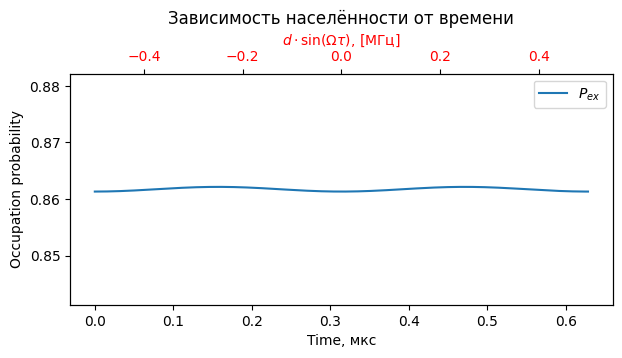

In [ ]:
print("ΩR = ", ΩR, "MHz , Δ = ", ω_sys - ω0, "MHz")

fig, ax = plt.subplots(figsize = (7, 3))

ax.plot(τ_mas, occupations, label="$P_{ex}$")
ax.set_xlabel('Time, мкс')
ax.set_ylabel('Occupation probability')
ax.legend()

ax_up = ax.twiny()
ax_up.set_xlabel('$d \cdot \sin(Ωτ)$, [МГц]', color='r')
ax_up.plot(d * sin(Ω * τ_mas), np.zeros_like(τ_mas), alpha=0, color='r')
ax_up.tick_params(axis='x', labelcolor='r')

ax.set_ylim(bottom=min(occupations) - 0.02, top=max(occupations) + 0.02)

plt.title("Зависимость населённости от времени")
plt.show()

# Основные параметры системы

In [ ]:
gamma = 1./(0.6*1e3) - 1./(160 * 1e3)
Q = 22000 #1e5
k1 = lambda w_cav_x: w_cav_x/(2*Q)
k2 = lambda w_cav_y: w_cav_y/(2*Q)
Pin = 4
kb = 1.38*1e-23
h = 1.05*1e-34
g1 = 0.38 * 1e-3 * sqrt(100/Q)
g2 = 0.38 * 1e-3 * sqrt(100/Q)

mu = 0
NF = 13.5
tau = 1


chi =lambda w_sys, w_ex, P_ex: (1./(w_sys - w_ex - 1j*gamma/2) + 1./(w_sys + w_ex + 1j*gamma/2))*(1 - 2*P_ex)

t = lambda w_sys, w_ex, w_cav, P_ex: 1j*sqrt(k1(w_cav)*k2(w_cav))/\
(w_cav - w_ex + g1**2*chi(w_sys, w_ex, P_ex) - 1j*(k1(w_cav)+k2(w_cav))/2)

r = lambda w_sys, w_ex, w_cav, P_ex: 1 + 1j*k1(w_cav)/(w_cav - w_ex + g1**2*chi(w_sys, w_ex, P_ex) - 1j*(k1(w_cav)+k2(w_cav))/2)


###  Зависимость пропускания от частоты модуляции

In [ ]:
ω_cav = 2800
ω_ex =  2800
ω_sys = 2800

res = []
res_phase = []
index_Δ =0
for p_ex in occup:
    Δ = Δ_mas[index_Δ]
    res.append(abs(r(ω_sys, ω_ex + Δ, ω_cav, p_ex))**2)
    res_phase.append(phase(t(ω_sys, ω_ex + Δ, ω_cav, p_ex)))
    index_Δ += 1

res_phase = np.unwrap(res_phase)

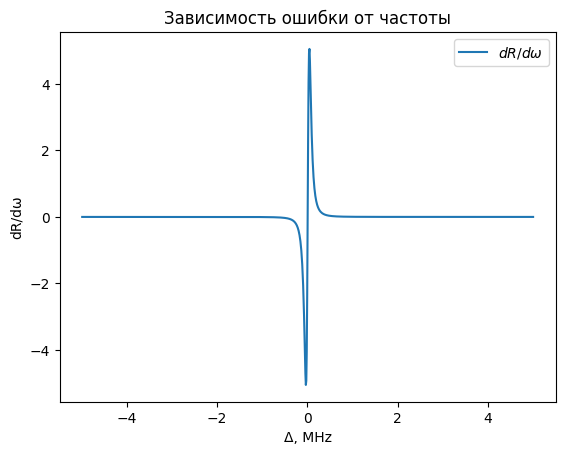

In [ ]:
ω_cav = 2800
ω_ex =  2800
ω_sys = 2800

res_phase = []
index_Δ =0
dR_dω = []

for p_ex in occup:
    Δ = Δ_mas[index_Δ]
    if index_Δ < len(Δ_mas)-1 :dR_dω.append( (res[index_Δ+1] - res[index_Δ])/Δ_step  * d)
    index_Δ += 1

plt.plot(Δ_mas[1:], dR_dω, label = "$dR/dω$")
plt.xlabel('Δ, MHz')
plt.ylabel('dR/dω')
plt.title('Зависимость ошибки от частоты')
plt.legend()

ΩR =  0.1 MHz, ω_sys = 2800 MHz, ω_ex = 2800 MHz, ω_cav = 2800 MHz


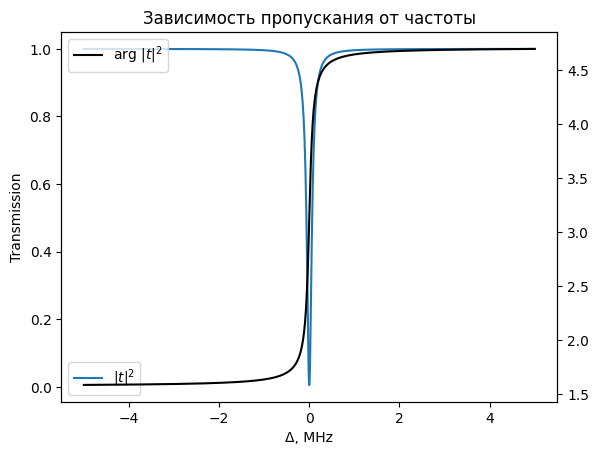

In [ ]:
print('ΩR = ',ΩR,"MHz, ω_sys =", ω_sys,"MHz, ω_ex =", ω_ex,"MHz, ω_cav =", ω_cav, "MHz")

plt.plot(Δ_mas, res, label = "$|t|^2$")
plt.xlabel('Δ, MHz')
plt.ylabel('Transmission')
plt.title('Зависимость пропускания от частоты')
plt.legend()

plt.twinx()
plt.plot(Δ_mas, res_phase,'k', label = 'arg $|t|^2$')
plt.legend()
plt.show()


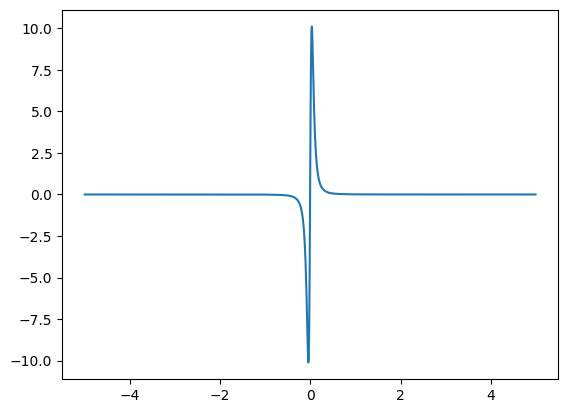

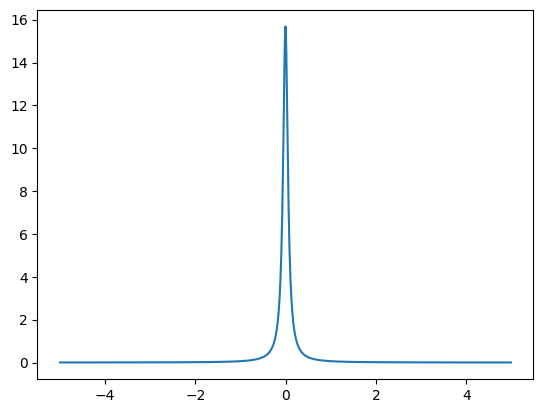

In [ ]:
dres_dB_derivate = []
dres_phase_dB_derivate = []

for step in range(len(Δ_mas)-1):
  dres_dB_derivate.append((res[step+1] - res[step])/Δ_step)
  dres_phase_dB_derivate.append((res_phase[step+1] - res_phase[step])/Δ_step)

plt.plot(Δ_mas[:-1], dres_dB_derivate)
plt.show()
plt.plot(Δ_mas[:-1], dres_phase_dB_derivate)


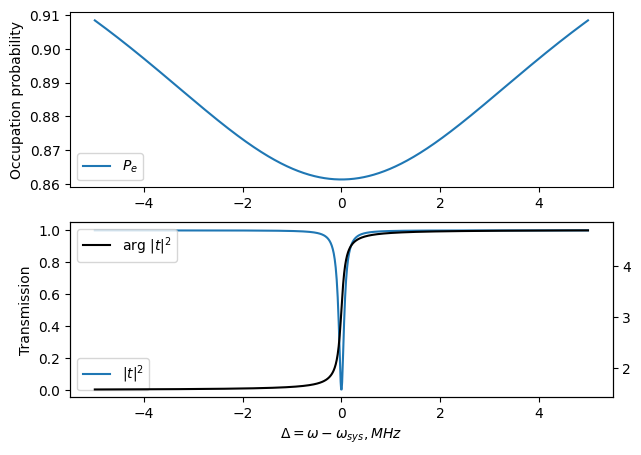

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 5))

ax1.plot(Δ_mas, occup, label="$P_{e}$")
#ax1.set_xlabel('Δ, МГц')
ax1.set_ylabel('Occupation probability')
ax1.legend()

ax2.plot(Δ_mas, res, label = "$|t|^2$")
ax2.set_xlabel('$Δ = ω - ω_{sys}, MHz$')
ax2.set_ylabel('Transmission')
ax2.legend()

ax2_right = ax2.twinx()
ax2_right.plot(Δ_mas, np.unwrap(res_phase),'k', label = 'arg $|t|^2$')
ax2_right.legend()
plt.show()

###Зависимость пропускания от времени

In [ ]:
ω_cav = 2800
ω_ex =  2800
ω_sys = 2800

res = []
res_phase = []
index_τ =0

for p_ex in occupations:
    τ = τ_mas[index_τ]
    res.append(abs(t(ω_sys, ω_ex + d*sin(Ω * τ), ω_cav, p_ex))**2)
    res_phase.append(phase(t(ω_sys, ω_ex + Δ, ω_cav, p_ex)))
    index_τ += 1

ΩR = 0.1 MHz , Δ = 0 MHz, d = 0.5 MHz, Ω = 10 MHz


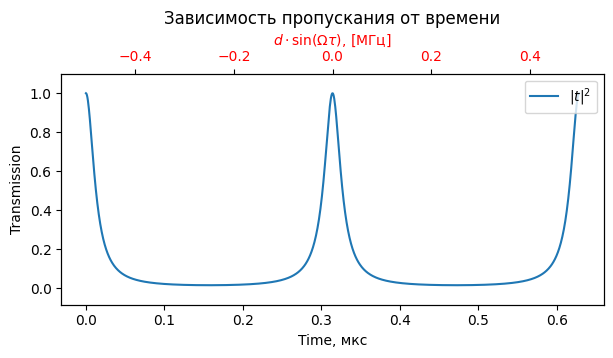

In [ ]:
print('ΩR =',ΩR,"MHz , Δ =", ω_sys - ω0, "MHz, d =",d, "MHz, Ω =",Ω,"MHz")

fig, ax = plt.subplots(figsize = (7, 3))

ax.plot(τ_mas, res, label="$|t|^2$")
ax.set_xlabel('Time, мкс')
ax.set_ylabel('Transmission')
ax.legend()

ax_up = ax.twiny()
ax_up.set_xlabel('$d \cdot \sin(Ωτ)$, [МГц]', color='r')
ax_up.plot(d * sin(Ω * τ_mas), np.zeros_like(τ_mas), alpha=0, color='r')
ax_up.tick_params(axis='x', labelcolor='r')

ax.set_ylim(bottom=min(res) - 0.1, top=max(res) + 0.1)

plt.title("Зависимость пропускания от времени")
plt.show()

ΩR = 0.1 MHz , Δ = 0 MHz, d = 0.5 MHz, Ω = 10 MHz


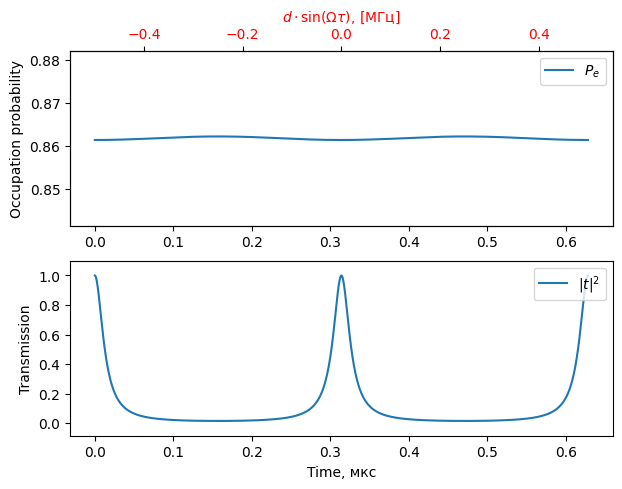

In [ ]:
print('ΩR =',ΩR,"MHz , Δ =", ω_sys - ω0, "MHz, d =",d, "MHz, Ω =",Ω,"MHz")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 5))

ax1.plot(τ_mas, occupations, label="$P_{e}$")
ax1.set_ylabel('Occupation probability')
ax1.legend()


ax_up1 = ax1.twiny()
ax_up1.set_xlabel('$d \cdot \sin(Ωτ)$, [МГц]', color='r')
ax_up1.plot(d * sin(Ω * τ_mas), np.zeros_like(τ_mas), alpha=0, color='r')
ax_up1.tick_params(axis='x', labelcolor='r')

ax1.set_ylim(bottom=min(occupations) - 0.02, top=max(occupations) + 0.02)


ax2.plot(τ_mas, res, label="$|t|^2$")
ax2.set_ylabel('Transmission')
ax2.set_xlabel('Time, мкс')
ax2.legend()

ax2.set_ylim(bottom=min(res) - 0.1, top=max(res) + 0.1)

plt.show()

### to be continue...

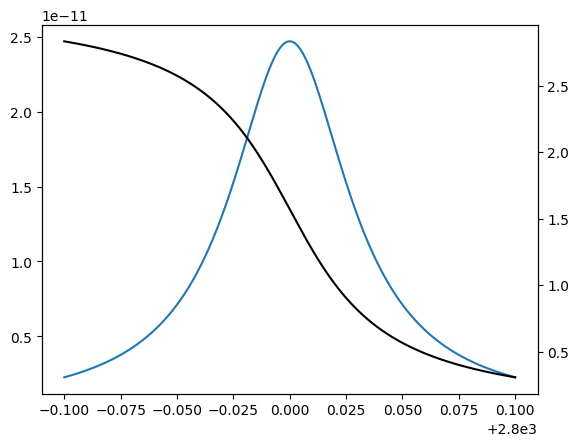

In [ ]:
plt.plot(w_cav_mas, res2)
plt.twinx()
plt.plot(w_cav_mas,np.unwrap(res2_ph),'k')

In [ ]:
w = 2.8*1e3
#w_cav_y = 2.82
w_cav_y = 2.8*1e3#!!!!!2.85
w_sys = w

dw = w_cav_y*0.005

#w_ex_mas = np.linspace(2.816, 2.824, 100)
#w_cav_mas = np.linspace(2.81, 2.83, 100)

w_ex_mas = np.linspace(2.7999, 2.8001, 100)*1e3#!!!!!!!!w_ex_mas = np.linspace(2.84, 2.86, 100)
w_cav_mas = np.linspace(2.7999, 2.8001, 100)*1e3#!!!!!!!w_cav_mas = np.linspace(2.79, 2.81, 100)

res2_map = np.zeros((len(w_ex_mas), len(w_cav_mas)))
res2_ph_map = np.zeros((len(w_ex_mas), len(w_cav_mas)))

res1_map = np.zeros((len(w_ex_mas), len(w_cav_mas)))
res1_ph_map = np.zeros((len(w_ex_mas), len(w_cav_mas)))
res1_reflection = np.zeros((len(w_ex_mas), len(w_cav_mas)))


for i in range(len(w_ex_mas)):
    for j in range(len(w_cav_mas)):

        res2_map[i][j] =      abs( S21(w_sys, w_ex_mas[i], w_cav_mas[j], w_cav_y))**2
        res2_ph_map[i][j] = phase( S21(w_sys, w_ex_mas[i], w_cav_mas[j], w_cav_y))


        res1_map[i][j] =      abs(   t(w_sys, w_ex_mas[i], w_cav_mas[j]         ))**2
        res1_ph_map[i][j] = phase(   t(w_sys, w_ex_mas[i], w_cav_mas[j]         ))
        res1_reflection[i][j] =      abs(   r(w_sys, w_ex_mas[i], w_cav_mas[j]         ))**2


max |S21|^2 =  8.057118058222208e-10
max |t|^2 =  1.0000090160976418
w_sys =  2800.0 GHZ, w_cav_y =  2800.0 GHz
1.0000090160407304


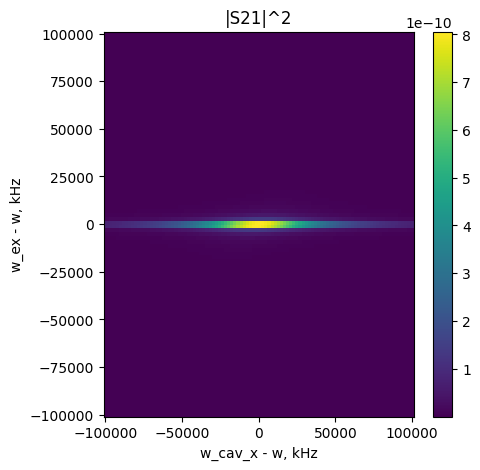

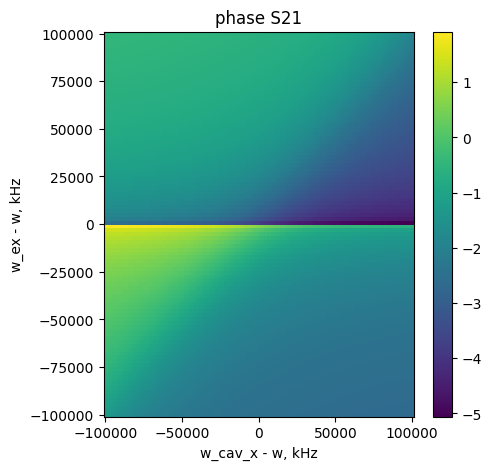

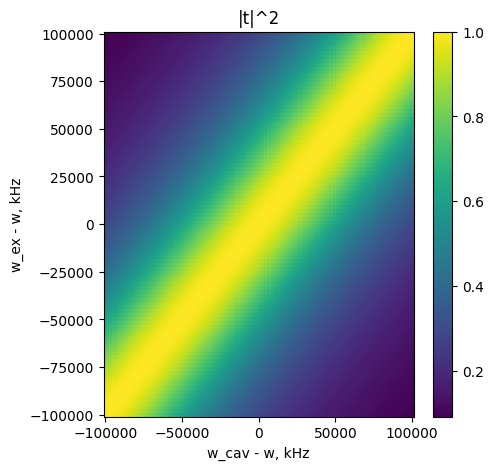

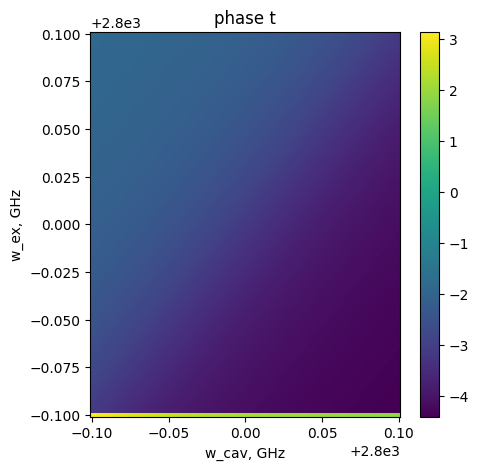

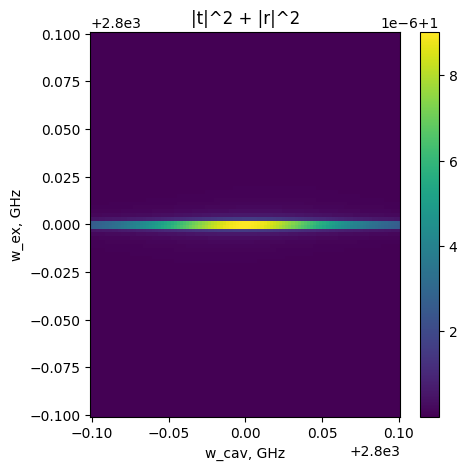

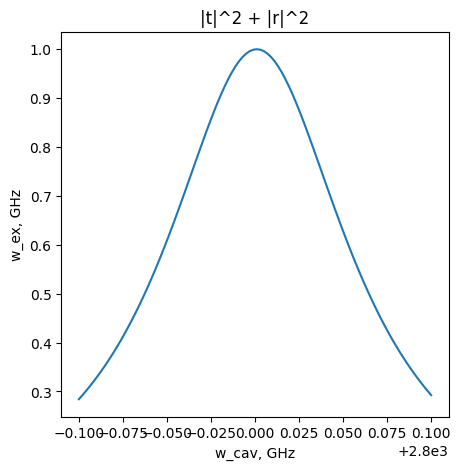

In [ ]:
print("max |S21|^2 = ", np.amax(res2_map))
print("max |t|^2 = ", np.amax(res1_map))
print("w_sys = ", w_sys, "GHZ, w_cav_y = ", w_cav_y, "GHz")
print(res1_map[50][50] - res1_reflection[50][50])



plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, res2_map)
plt.colorbar()
plt.xlabel('w_cav_x - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('|S21|^2')
plt.show()


plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, np.unwrap(res2_ph_map))
plt.colorbar()
plt.xlabel('w_cav_x - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('phase S21')
plt.show()
#'''


plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, res1_map)
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('|t|^2')
plt.show()


plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor(w_cav_mas, w_ex_mas, np.unwrap(res1_ph_map))
plt.colorbar()
plt.xlabel('w_cav, GHz')
plt.ylabel('w_ex, GHz')
plt.title('phase t')
plt.show()
#'''

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor(w_cav_mas, w_ex_mas, res1_map + res1_reflection)
plt.colorbar()
plt.xlabel('w_cav, GHz')
plt.ylabel('w_ex, GHz')
plt.title('|t|^2 + |r|^2')
plt.show()

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.plot(w_cav_mas, res1_map[50, :])
plt.xlabel('w_cav, GHz')
plt.ylabel('w_ex, GHz')
plt.title('|t|^2 + |r|^2')
plt.show()

# Погрешность измерения частоты перехода, вариант 1

In [ ]:
w = 2.8*1e3
w_cav_y = w

w_sys_l = w - 1e-6
w_sys_r = w + 1e-6

detune = 1e-4

w_ex_mas =  linspace(w - detune, w + detune, 101)
w_cav_mas = linspace(w - detune, w + detune, 101)


δw1 = zeros((len(w_ex_mas), len(w_cav_mas)))
δw2 = zeros((len(w_ex_mas), len(w_cav_mas)))
dSdw = zeros((len(w_ex_mas), len(w_cav_mas)))
dtdw = zeros((len(w_ex_mas), len(w_cav_mas)))

φ1 = zeros((len(w_ex_mas), len(w_cav_mas)))
φ2 = zeros((len(w_ex_mas), len(w_cav_mas)))
𝜉1 = zeros((len(w_ex_mas), len(w_cav_mas)))
𝜉2 = zeros((len(w_ex_mas), len(w_cav_mas)))

const = 10**(NF/10) * (Pin *tau/(h*w*1e9))**(-0.5) * 1e9 / (28*1e9) #!!!!!!!!!!!!!

for i in range(len(w_ex_mas)):

    S_l = zeros(len(w_cav_mas))
    S_r = zeros(len(w_cav_mas))
    S_0 = zeros(len(w_cav_mas))
    t_l = zeros(len(w_cav_mas))
    t_r = zeros(len(w_cav_mas))
    t_0 = zeros(len(w_cav_mas))

    for j in range(len(w_cav_mas)):

        S_l[j] = phase( S21(w_sys_l, w_ex_mas[i], w_cav_mas[j], w_cav_y))
        S_r[j] = phase( S21(w_sys_r, w_ex_mas[i], w_cav_mas[j], w_cav_y))
        S_0[j] = abs(S21(w_sys, w_ex_mas[i], w_cav_mas[j], w_cav_y))**2

        t_l[j] = phase( t(w_sys_l, w_ex_mas[i], w_cav_mas[j] ))
        t_r[j] = phase( t(w_sys_r, w_ex_mas[i], w_cav_mas[j] ))
        t_0[j] = abs(   t(w_sys  , w_ex_mas[i], w_cav_mas[j] ))**2

    S_l = np.unwrap(S_l)
    S_r = np.unwrap(S_r)
    dSdw[i][:] = (S_l - S_r)/(w_sys_r - w_sys_l)
    δw2[i][:] = (dSdw[i][:])**(-1) / (S_0)**(0.5)
    φ2[i][:] = (dSdw[i][:])
    𝜉2[i][:] = (dSdw[i][:])**(-1)

    t_l = np.unwrap(t_l)
    t_r = np.unwrap(t_r)
    dtdw[i][:] = (t_l - t_r)/(w_sys_r - w_sys_l)
    δw1[i][:] = (dtdw[i][:])**(-1) / (t_0)**(0.5)
    φ1[i][:] = (dtdw[i][:])
    𝜉1[i][:] = (dtdw[i][:])**(-1)

w_sys =  2800.0 HHz, w_cav_y =  2800.0 HHz
2-mode: min δw =  127.22706769379053 pT
1-mode: min δw =  508.9429072982134 pT
min δw2/δw1 =  0.24440299763572584
max δw1/δw2 =  4.09160284314706
6.854655582343784e-12


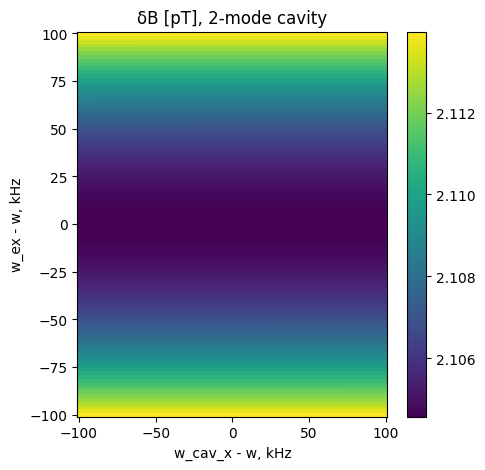

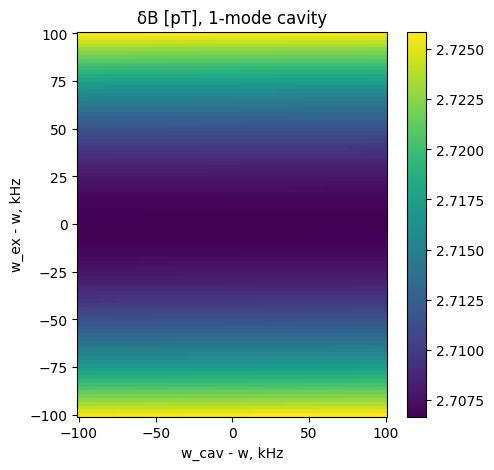

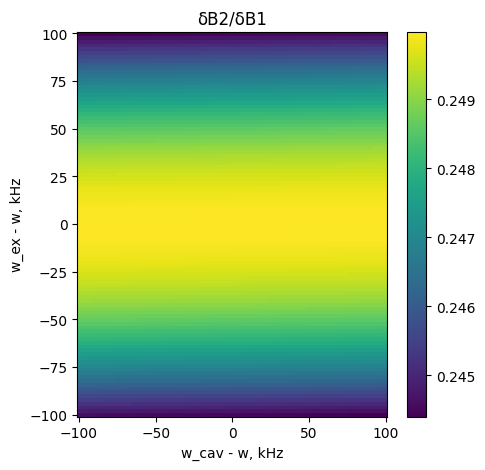

min δB2/δB1 =  0.24440299763572584


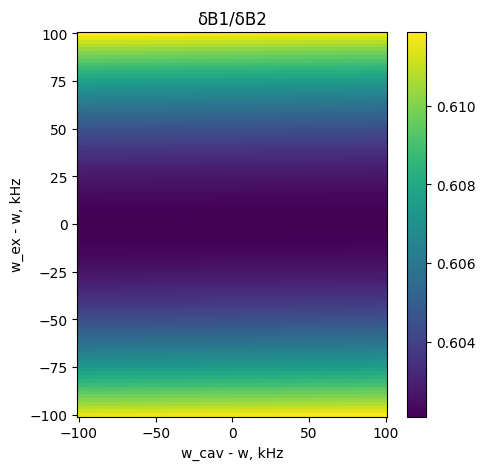

max δB1/δB2 =  4.09160284314706


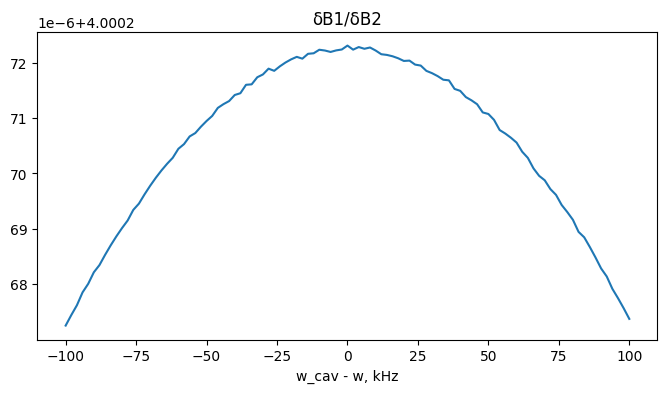

min δB1/δB2 по уровню w=2.8 GHz 4.000267253028026


In [ ]:
print("w_sys = ", w_sys, "HHz, w_cav_y = ", w_cav_y, "HHz")
print("2-mode: min δw = ", np.amin(const*δw2) * 1e12, "pT")
print("1-mode: min δw = ", np.amin(const*δw1)* 1e12, "pT")
print("min δw2/δw1 = ", np.amin(abs(δw2/δw1)))
print("max δw1/δw2 = ", np.amax(abs(δw1/δw2)))
print(const)

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, np.log10(const*δw2 * 1e12))
plt.colorbar()
plt.xlabel('w_cav_x - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('δB [pT], 2-mode cavity')
plt.show()


plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, np.log10(const*δw1 * 1e12))
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('δB [pT], 1-mode cavity')
plt.show()

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, δw2/δw1)
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('δB2/δB1')
plt.show()
print("min δB2/δB1 = ", np.amin(abs(δw2/δw1)))

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas-w)*1e6, np.log10(δw1/δw2))
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('δB1/δB2')
plt.show()
print("max δB1/δB2 = ", np.amax(abs(δw1/δw2)))
'''

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot(w_cav_mas, abs(φ1[50][:]), label = "1 mode")
ax.plot(w_cav_mas, abs(φ2[50][:]), label = "2 mode")
ax.set_xlabel("w_cav, GHZ")
#ax.set_ylabel("dφ1/dw, dφ2/dw")
plt.title('dφ/dw')
plt.yscale("log")
ax.legend(loc=0)
plt.show()

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot(w_cav_mas, abs(𝜉1[50][:]), label = "1 mode")
ax.plot(w_cav_mas, abs(𝜉2[50][:]), label = "2 mode")
ax.set_xlabel("w_cav, GHZ")
#ax.set_ylabel("dw/dφ1, dw/dφ2")
plt.title('dw/dφ')
plt.yscale("log")
ax.legend(loc=0)
plt.show()


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot(w_cav_mas, abs(δw1[50][:]), label = "1 mode")
ax.plot(w_cav_mas, abs(δw2[50][:]), label = "2 mode")
ax.set_xlabel("w_cav, GHZ")
plt.title("δw = δф*dw/dφ")
plt.yscale("log")
ax.legend(loc=0)
plt.show()
'''

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot((w_cav_mas - w)*1e6, δw1[50][:]/δw2[50][:])
plt.xlabel('w_cav - w, kHz')
plt.title('δB1/δB2')
plt.show()

print('min δB1/δB2 по уровню w=2.8 GHz', np.min(abs(δw1[50][:]/δw2[50][:])))

# Чувствиетльность вариант 2

In [ ]:
R = 50
electron = 1.602176634 * 1e-19
SNR = (Pin / R / electron**2)**(0.5)

print(SNR)

1.7653653565554307e+18


In [ ]:
w = 2.8*1e3
w_cav_y = w

w_sys_l = w - 1e-6
w_sys_r = w + 1e-6

detune = 1e-4

w_ex_mas =  linspace(w - detune, w + detune, 101)
w_cav_mas = linspace(w - detune, w + detune, 101)


sens1 = zeros((len(w_ex_mas), len(w_cav_mas)))
sens2 = zeros((len(w_ex_mas), len(w_cav_mas)))
dSdw = zeros((len(w_ex_mas), len(w_cav_mas)))
dtdw = zeros((len(w_ex_mas), len(w_cav_mas)))

φ1 = zeros((len(w_ex_mas), len(w_cav_mas)))
φ2 = zeros((len(w_ex_mas), len(w_cav_mas)))
𝜉1 = zeros((len(w_ex_mas), len(w_cav_mas)))
𝜉2 = zeros((len(w_ex_mas), len(w_cav_mas)))

R = 50
electron = 1.602176634 * 1e-19
SNR = (Pin / R / electron**2)**(0.25)
#SNR = (Pin/electron)**(0.5)
const = 10**(NF/10) * (SNR)**(-1) * 1e9 / (28*1e9) #!!!!!!!!!

for i in range(len(w_ex_mas)):

    S_l = zeros(len(w_cav_mas))
    S_r = zeros(len(w_cav_mas))
    S_0 = zeros(len(w_cav_mas))
    t_l = zeros(len(w_cav_mas))
    t_r = zeros(len(w_cav_mas))
    t_0 = zeros(len(w_cav_mas))

    for j in range(len(w_cav_mas)):

        S_l[j] = phase( S21(w_sys_l, w_ex_mas[i], w_cav_mas[j], w_cav_y))
        S_r[j] = phase( S21(w_sys_r, w_ex_mas[i], w_cav_mas[j], w_cav_y))
        S_0[j] = abs(S21(w_sys, w_ex_mas[i], w_cav_mas[j], w_cav_y))**2

        t_l[j] = phase( t(w_sys_l, w_ex_mas[i], w_cav_mas[j] ))
        t_r[j] = phase( t(w_sys_r, w_ex_mas[i], w_cav_mas[j] ))
        t_0[j] = abs(   t(w_sys  , w_ex_mas[i], w_cav_mas[j] ))**2

    S_l = np.unwrap(S_l)
    S_r = np.unwrap(S_r)
    dSdw[i][:] = (S_l - S_r)/(w_sys_r - w_sys_l)
    sens2[i][:] = (dSdw[i][:])**(-1) / (S_0)**(0.25)
    φ2[i][:] = (dSdw[i][:])
    𝜉2[i][:] = (dSdw[i][:])**(-1)

    t_l = np.unwrap(t_l)
    t_r = np.unwrap(t_r)
    dtdw[i][:] = (t_l - t_r)/(w_sys_r - w_sys_l)
    sens1[i][:] = (dtdw[i][:])**(-1) / (t_0)**(0.25)
    φ1[i][:] = (dtdw[i][:])
    𝜉1[i][:] = (dtdw[i][:])**(-1)

w_sys =  2800.0 HHz, w_cav_y =  2800.0 HHz
2-mode: min sensitivity [pT/sqrt(Hz)] =  224.10559517333388
1-mode: min sensitivity [pT/sqrt(Hz)]=  402123.51879997243
min sens2/sens1 =  0.0005429008535187145
max sens1/sens2 =  1841.9569494479135
6.017618743074807e-10


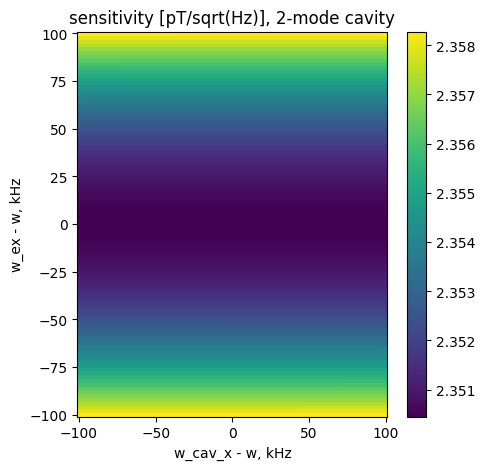

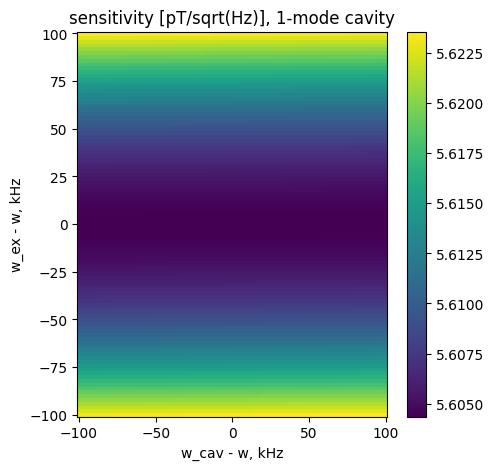

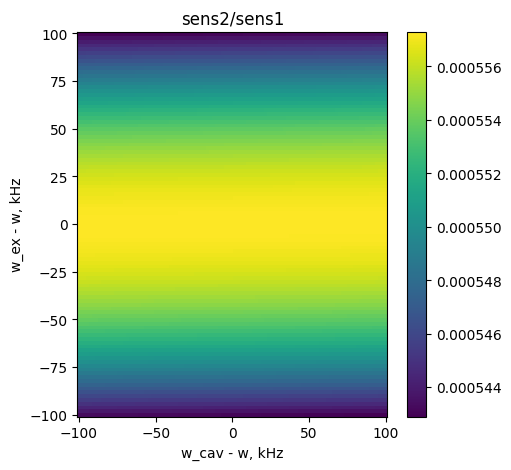

min δw2/δw1 =  0.0005429008535187145


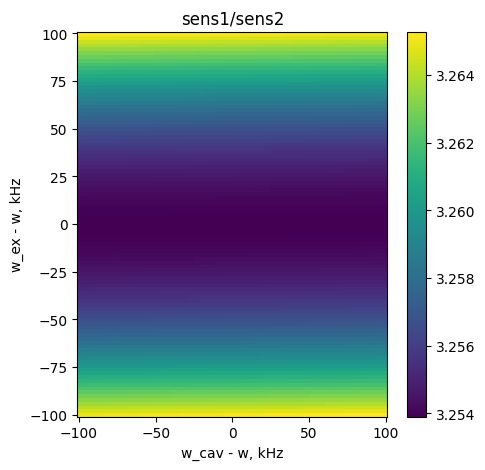

max sens1/sens2 =  1841.9569494479135


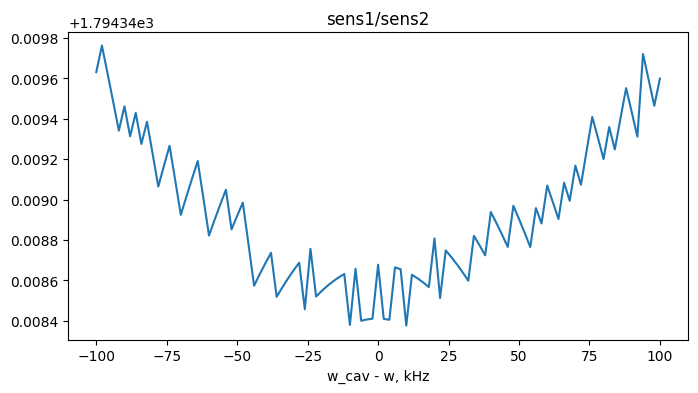

min sens1/sens2 по уровню w=2.8 1794.3483766345307


In [ ]:
print("w_sys = ", w_sys, "HHz, w_cav_y = ", w_cav_y, "HHz")
print("2-mode: min sensitivity [pT/sqrt(Hz)] = ", 1e12 * np.amin(const * sens2))
print("1-mode: min sensitivity [pT/sqrt(Hz)]= ", 1e12 * np.amin(const * sens1))
print("min sens2/sens1 = ", np.amin(sens2/sens1))
print("max sens1/sens2 = ", np.amax(sens1/sens2))
print(const)

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas - w)*1e6, np.log10(const * sens2 * 1e12))
plt.colorbar()
plt.xlabel('w_cav_x - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('sensitivity [pT/sqrt(Hz)], 2-mode cavity')
plt.show()


plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas - w)*1e6, np.log10(const * sens1 * 1e12))
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('sensitivity [pT/sqrt(Hz)], 1-mode cavity')
plt.show()

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas - w)*1e6,  sens2/sens1)
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('sens2/sens1')
plt.show()
print("min δw2/δw1 = ", np.amin( sens2/sens1))

plt.figure(figsize=(5,5))
plt.subplot(111)
plt.pcolor((w_cav_mas - w)*1e6, (w_ex_mas - w)*1e6, np.log10( sens1/sens2))
plt.colorbar()
plt.xlabel('w_cav - w, kHz')
plt.ylabel('w_ex - w, kHz')
plt.title('sens1/sens2')
plt.show()
print("max sens1/sens2 = ", np.amax( sens1/sens2))

'''
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot((w_cav_mas - w)*1e6, abs(φ1[50][:]) * 1e-9, label = "1 mode")
ax.plot((w_cav_mas - w)*1e6, abs(φ2[50][:]) * 1e-9, label = "2 mode")
ax.set_xlabel("w_cav - w, kHZ")
#ax.set_ylabel("dφ1/dw, dφ2/dw")
plt.title('dφ/dw')
plt.yscale("log")
ax.legend(loc=0)
plt.show()

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot((w_cav_mas - w)*1e6, abs(𝜉1[50][:]) * 1e9, label = "1 mode")
ax.plot((w_cav_mas - w)*1e6, abs(𝜉2[50][:]) * 1e9, label = "2 mode")
ax.set_xlabel("w_cav - w, kHZ")
#ax.set_ylabel("dw/dφ1, dw/dφ2")
plt.title('dw/dφ')
plt.yscale("log")
ax.legend(loc=0)
plt.show()


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot((w_cav_mas - w)*1e6, abs(sens1[50][:]), label = "1 mode")
ax.plot((w_cav_mas - w)*1e6, abs(sens2[50][:]), label = "2 mode")
ax.set_xlabel("w_cav - w, kHZ")
plt.title("sensitivity = (SNR)^-1*dw/dφ * 1/gamma")
plt.yscale("log")
ax.legend(loc=0)
plt.show()
'''

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot((w_cav_mas - w)*1e6, abs(sens1[50][:]/sens2[50][:]))
plt.xlabel('w_cav - w, kHz')
plt.title('sens1/sens2')
plt.show()

print('min sens1/sens2 по уровню w=2.8', np.min(sens1[50][:]/sens2[50][:]))

In [ ]:
(Pin *tau/(h*w*1e9))**(0.5)

3688555567816.5874

In [ ]:
(Pin / R / electron**2)**(0.25)

1328670522.1970685

# Вычисление чувствительности

min sensitivity =  48.448717349742736 pT/sqrt(Hz)


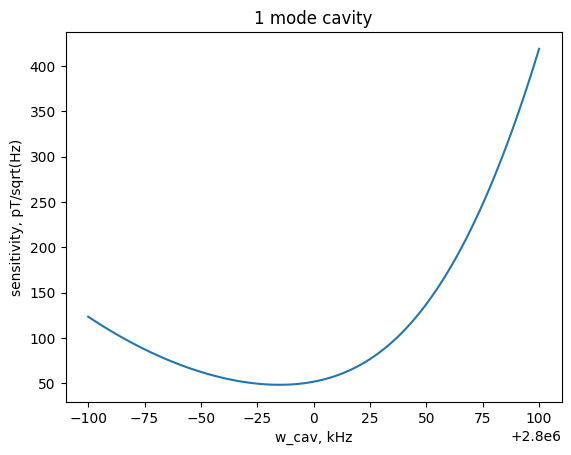

In [ ]:
mode_numbers = 1
Pin = 4
R = 50
en = 20 * 1e-9
gamma_gyro = 28
D = 2.87
B_test_zero = 40*1e-4
B_test_0 = 39*1e-4
B_test_1 = 41*1e-4

w = 2.8 # gamma_gyro * B_test_zero + D
w_sys = w
w_cav_x = w
w_cav_y = w
w_ex = w

#B_test = linspace(B_test_0, B_test_1, 100)
#w_mas = gamma_gyro * B_test + D

w_sys_mas = linspace(2.799, 2.801, 1000)
w_cav_x_mas = linspace(2.7999, 2.8001, 100)
#w_cav_x_mas = [2.801]
dSignal_dB_max = []

for w_cav_x_step in w_cav_x_mas:
    signal = []
    for w_sys_step in w_sys_mas:
        if mode_numbers == 1: signal.append( sqrt(R * Pin * abs(t(w_sys_step, w_ex, w_cav_x_step))**2 ))
        if mode_numbers == 2: signal.append( sqrt(R * Pin * abs(S21(w_sys_step, w_ex, w_cav_x_step, w_cav_y))**2 ))

    dSignal_dB = []
    for i in range(len(w_sys_mas)-1):
        dSignal_dB.append(     (signal[i+1] - signal[i])/(w_sys_mas[i+1] - w_sys_mas[i])*gamma_gyro )

    dSignal_dB_max.append(np.max(dSignal_dB))

dSignal_dB_max = np.array(dSignal_dB_max)


'''
plt.plot(w_sys_mas, signal)
plt.show()
plt.plot(w_sys_mas[1:], np.array(dSignal_dB))

print("sensitivity = ", en*1./dSignal_dB_max *1e12, "pT/sqrt(Hz)")
'''
plt.plot(w_cav_x_mas*1e6,  en*1./dSignal_dB_max*1e12 )
plt.xlabel('w_cav, kHz')
plt.ylabel('sensitivity, pT/sqrt(Hz)')
if mode_numbers == 1: plt.title('1 mode cavity')
if mode_numbers == 2: plt.title('2 mode cavity')

print("min sensitivity = ", np.min(en*1./dSignal_dB_max *1e12), "pT/sqrt(Hz)")


## чувствительность через d(Im Г)/dw

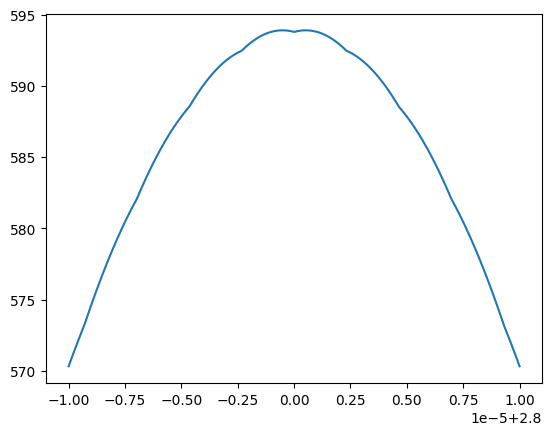

min sensitivity =  33.67592198171154 pT/sqrt(Hz)


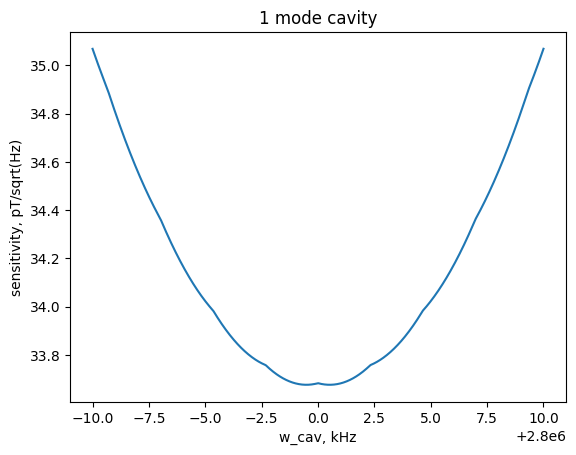

In [ ]:
mode_numbers = 1

Pin = 4
R = 50
en = 20 * 1e-9
gamma_gyro = 28
D = 2.87
B_test_zero = 40*1e-4
B_test_0 = 39*1e-4
B_test_1 = 41*1e-4

w = 2.8
w_sys = w
w_cav_x = w
w_cav_y = w
w_ex = w

step = w_sys*1e-7
w_sys_mas   = linspace(2.799, 2.801, 100)
w_cav_x_mas = linspace(2.79999, 2.80001, 1000)
#w_cav_x_mas = [2.8]
dSignal_dB_max = []

for w_cav_x_step in w_cav_x_mas:
    dSignal_dB = []
    for w_sys_step in w_sys_mas:
        if mode_numbers == 1:
            signal_left = sqrt(R * Pin) * r(w_sys_step - step, w_ex, w_cav_x_step).imag
            signal_right = sqrt(R * Pin) * r(w_sys_step + step, w_ex, w_cav_x_step).imag

        if mode_numbers == 2:
            signal_left = sqrt(R * Pin) * S21(w_sys_step - step, w_ex, w_cav_x_step, w_cav_y).imag
            signal_right = sqrt(R * Pin) * S21(w_sys_step + step, w_ex, w_cav_x_step, w_cav_y).imag

        dSignal_dB.append( abs(signal_right - signal_left)/(2*step)*gamma_gyro    )
    dSignal_dB_max.append(np.max(dSignal_dB))



dSignal_dB_max = np.array(dSignal_dB_max)

plt.plot(w_cav_x_mas,  dSignal_dB_max)
plt.show()

plt.plot(w_cav_x_mas*1e6,  en*1./dSignal_dB_max*1e12 )
plt.xlabel('w_cav, kHz')
plt.ylabel('sensitivity, pT/sqrt(Hz)')
if mode_numbers == 1: plt.title('1 mode cavity')
if mode_numbers == 2: plt.title('2 mode cavity')

print("min sensitivity = ", np.min(en*1./dSignal_dB_max *1e12), "pT/sqrt(Hz)")



# Инверсия населённостей

In [ ]:
chi =lambda w_sys, w_ex, inv: (1./(w_sys - w_ex - 1j*gamma/2) + 1./(w_sys + w_ex + 1j*gamma/2)) * inv


znamenatel = lambda w_sys, w_ex, w_cav_x, w_cav_y, inv: \
(1j*(w_ex - w_cav_x) - 1j*g1**2*chi(w_sys, w_ex, inv) - k1(w_cav_x)/2)*\
(1j*(w_ex - w_cav_y) - 1j*g2**2*chi(w_sys, w_ex, inv) - k1(w_cav_y)/2) + \
g1**2*g2**2*chi(w_sys, w_ex, inv)*chi(w_sys, w_ex, inv)

S21 = lambda w_sys, w_ex, w_cav_x, w_cav_y, inv: g1*g2*chi(w_sys, w_ex, inv)*sqrt(k1(w_cav_x)*k1(w_cav_y))/\
znamenatel(w_sys, w_ex, w_cav_x, w_cav_y, inv)

t = lambda w_sys, w_ex, w_cav_x, inv: 1j*sqrt(k1(w_cav_x)*k2(w_cav_x))/\
(w_cav_x - w_ex + g1**2*chi(w_sys, w_ex, inv) - 1j*(k1(w_cav_x)+k2(w_cav_x))/2)

In [ ]:
mode_numbers = 2

Pin = 4
R = 50
en = 20 * 1e-9
gamma_gyro = 28
D = 2.87
B_test_zero = 40*1e-4
B_test_0 = 39*1e-4
B_test_1 = 41*1e-4

w = 2.8 # gamma_gyro * B_test_zero + D
w_sys = w
w_cav_x = w
w_cav_y = w
w_ex = w

#B_test = linspace(B_test_0, B_test_1, 100)
#w_mas = gamma_gyro * B_test + D

w_sys_mas = linspace(2.75, 2.85, 1000)
w_cav_x_mas = linspace(2.79, 2.81, 100)
#w_cav_x_mas = [2.801]

sensitivity = []
inv_mas = linspace(0.2, 1, 50)
inv_mas = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for inv in inv_mas:
    dSignal_dB_max = []
    for w_cav_x_step in w_cav_x_mas:
        signal = []
        for w_sys_step in w_sys_mas:
            if mode_numbers == 1: signal.append( sqrt(R * Pin * abs(t(w_sys_step, w_ex, w_cav_x_step, inv))**2 ))
            if mode_numbers == 2: signal.append( sqrt(R * Pin * abs(S21(w_sys_step, w_ex, w_cav_x_step, w_cav_y, inv))**2 ))

        dSignal_dB = []
        for i in range(len(w_sys_mas)-1):
            dSignal_dB.append(     (signal[i+1] - signal[i])/(w_sys_mas[i+1] - w_sys_mas[i])*gamma_gyro )

        dSignal_dB_max.append(np.max(dSignal_dB))
    dSignal_dB_max = np.array(dSignal_dB_max)
    sensitivity.append(np.min(en*1./dSignal_dB_max *1e12))


plt.plot(inv_mas/2 + 0.5, sensitivity)
plt.xlabel('ground state population')
plt.ylabel('sensitivity, pT/sqrt(Hz)')
if mode_numbers == 1: plt.title('1 mode cavity')
if mode_numbers == 2: plt.title('2 mode cavity')


'''
plt.plot(w_sys_mas, signal)
plt.show()
plt.plot(w_sys_mas[1:], np.array(dSignal_dB))

print("sensitivity = ", en*1./dSignal_dB_max *1e12, "pT/sqrt(Hz)")
'''

'''
plt.plot(w_cav_x_mas/w,  en*1./dSignal_dB_max*1e12 )
plt.xlabel('w_cav/w, GHz')
plt.ylabel('sensitivity, pT/sqrt(Hz)')
if mode_numbers == 1: plt.title('1 mode cavity')
if mode_numbers == 2: plt.title('2 mode cavity')

print("min sensitivity = ", np.min(en*1./dSignal_dB_max *1e12), "pT/sqrt(Hz)")
'''

TypeError: <lambda>() takes 4 positional arguments but 5 were given

In [ ]:
(4 * 1/(1.05*1e-34*w*1e9))**(0.5)*10**(-NF/20)

779572176540.8796

# Сравнение коэффициента отражения с коэф-ом в статье

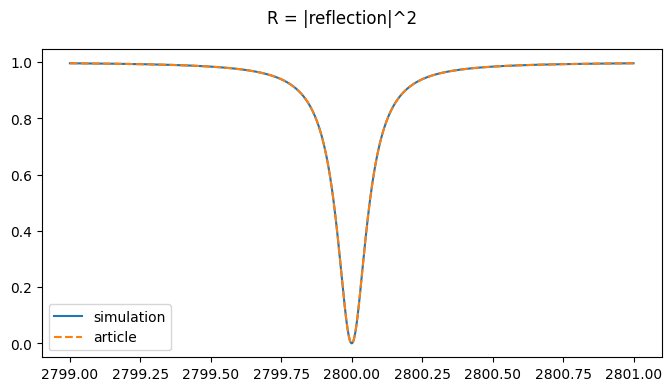

<ipython-input-12-7430f31df03a>:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=0)


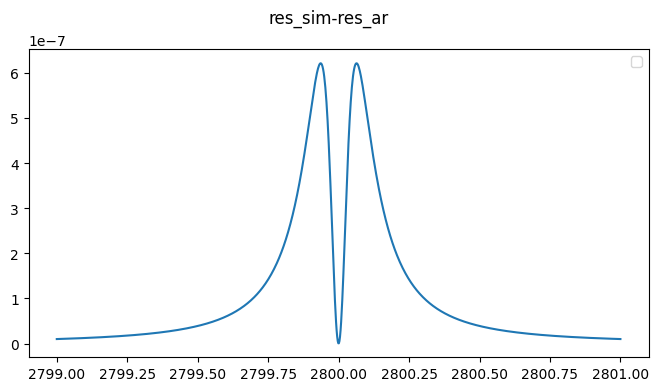

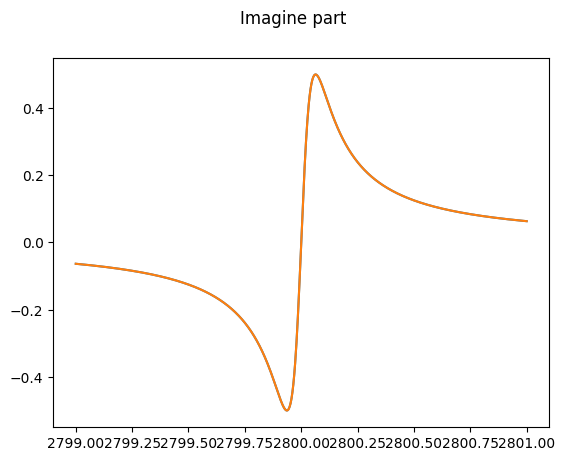

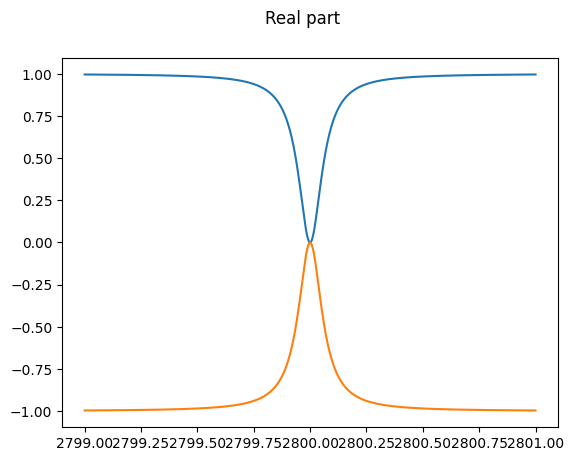

In [ ]:
kc_ar = lambda w_cav: w_cav/Q           #+
kc1_ar = lambda w_cav: kc_ar(w_cav)/2   #+
kc2_ar = lambda w_cav: kc_ar(w_cav)/2   #+
#kc_ar =  2*pi*200 *1e-6          #change
#kc1_ar = 2*pi *25.3 * 1e-6       #change
#kc2_ar = 2 *pi * 33.4 * 1e-6     #change

ks_ar = 2./(8*1e3)         #+
#ks_ar = 2*pi*5.24 * 1e-3    #change
kop_ar = 1./(130 * 1e3)    #+
ncav_ar = Q*Pin/(h*(2.8*1e9)**2) #1.5*1e20     #!!!!!!!!!!
geff_ar = 2*pi*0.7 * 1e-3  #
N_ar = 1.4 * 1e15          #
gs_ar = geff_ar/sqrt(N_ar)#
#gs_ar = 1e-3 * 1e-9        #   change

Г = lambda w_sys, w_ex, w_cav: -1+kc1_ar(w_cav)/(kc_ar(w_cav)/2 + 1j * (w_ex-w_cav) + geff_ar**2/((ks_ar/2) + 1j*(w_ex - w_sys) + \
                                gs_ar**2*ncav_ar*ks_ar/(2*kop_ar)/(ks_ar/2 -1j*(w_ex-w_sys) )))
w = 2.8*1e3
w_sys = w
w_ex = w

res_sim = []
res_ar = []
res_sim_im = []
res_ar_im = []
res_sim_re = []
res_ar_re = []

w_cav_mas = linspace(2.799, 2.801, 1000)*1e3

for w_step in w_cav_mas:
    res_sim.append( abs(r(w_sys, w_ex, w_step))**2  )
    res_ar.append( abs(Г(w_sys, w_ex, w_step))**2  )

    res_sim_im.append(r(w_sys, w_ex, w_step).imag)
    res_ar_im.append(Г(w_sys, w_ex, w_step).imag)

    res_sim_re.append(r(w_sys, w_ex, w_step).real)
    res_ar_re.append(Г(w_sys, w_ex, w_step).real)


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot(w_cav_mas, res_sim, label = "simulation", linestyle = '-')
ax.plot(w_cav_mas, res_ar, label = "article", linestyle = 'dashed')
fig.suptitle("R = |reflection|^2")
ax.legend(loc=0)
plt.show()

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))
ax.plot(w_cav_mas, (np.array(res_sim) - np.array(res_ar)  ))
fig.suptitle("res_sim-res_ar")
ax.legend(loc=0)
plt.show()


plt.plot(w_cav_mas, res_sim_im)
plt.plot(w_cav_mas, res_ar_im)
plt.suptitle("Imagine part")
plt.show()

plt.plot(w_cav_mas, res_sim_re)
plt.plot(w_cav_mas, res_ar_re)
plt.suptitle("Real part")
plt.show()



Q*Pin/(h*(2.8*1e9)**2)

In [ ]:
Q*Pin/(h*(2.8*1e9)**2)

1.0689990281827017e+20

In [ ]:
1./((exp(h*2.8*1e9/kb/293)-1))

13752.561230544536

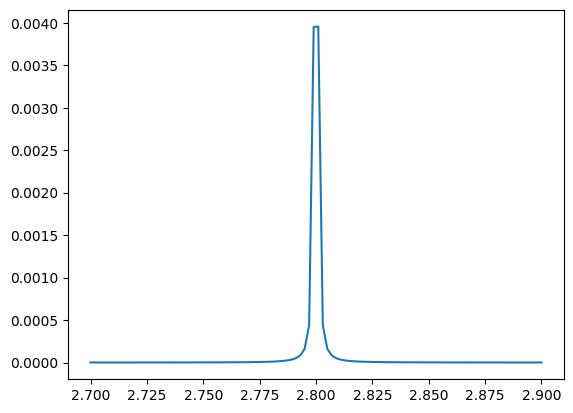

In [ ]:
w_cav_mas = linspace(2.7, 2.9, 100)
plt.plot(w_cav_mas, abs(t(2.8, 2.8, w_cav_mas))**2)